In [33]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('#toggleButton').val('Show Code')
 } else {
 $('div.input').show();
 $('#toggleButton').val('Show Code')
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" id = "toggleButton" value="Hide Code"></form>''')

In [16]:
import numpy as np
import pandas as pd
import os
from IPython.display import HTML
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score,classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc as sk_auc



<h1><center> Gradient Boosting Trees using Python </center></h1>



<h2>Introduction </h2>
<br>

<li> Boosting algorithms are a family of machine learning algorithms that combine "weak learners" to form a "strong learner". A weak learner is any machine learning algorithm that has better accuracy than simply guessing, but only performs well on a subset of the data. Boosting works by using these to solve subsections of the problem, by peeling them away so future boosting iterations can solve the remaining sections.

<li> For instance, an algorithm classifying animals at a zoo only classifies zebras correctly, most of the time, and simply guesses for other animals. Boosting involves using the model for zebras while other weak learners to focus on the remaining animals.
    
<li> In the case of Gradient Boosting Trees, Decision Trees are the weak learners.  

<br>
<h2> Gradient Boosting Regression </h2>
<br>    
For Regression, the algorithm works as follows:
<ol>
<li> We predict a 0 for each value and calculate the error over the dataset.
<li> The tree begins with the initial split into 2 groups. Average difference of each value and the initial prediction of 0. Each possible split of the tree is examined. I.e. the data is split around each value in the dataset. 
<li> The split is selected so that values closest to each other are clumped together (i.e Sum of Squared errors of Split Value and each datapoint) is minimized.
<li> The average error in the 2 subsets is added to all values in the group.
<li> Split each dataset again into 2 groups and repeat the process until a certain depth is reached.
</ol>    
    
    
The dataset used here is the Online News Popularity Dataset from <a href = http://archive.ics.uci.edu/ml/datasets/Online+News+Popularity>UCI Machine Learning Repository </a>.


#### Step 1: Import the dataset
We inspect the distribution of variables in the dataset

In [45]:
# Read csv data
news_data = pd.read_csv("OnlineNewsPopularity.csv")

# Remove white space from column names:
news_data.columns = news_data.columns.str.lstrip()

# Check data types of the variables
display(news_data.describe())


,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,354.530471,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,...,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184
std,214.163767,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,...,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,164.000000,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,...,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,946.000000
50%,339.000000,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,...,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1400.000000
75%,542.000000,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,...,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000,2800.000000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000


#### Step 2: Data pre-processing
Given the variance of the dependant variable, we convert it to binary and change the problem to one of classification instead of regression

In [25]:
# Create binary variable popularity based on number of shares:
news_data.loc[news_data.shares >= 1400,'popular'] = 1
news_data.loc[news_data.shares < 1400,'popular'] = 0

In [26]:
# Seperate target and training features
X = news_data.drop(['popular','shares','url'],axis = 1)
y = news_data['popular']
y = pd.Series(y)


#### Step 3: Split into train, test and validation sets

We use min-max scaling to normalize the data


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.3,
                                                   random_state = 123)

# Scaling using MinMaxScaler()
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# Split training data into testing and validation

X_train_sub, X_validation_sub, y_train_sub, y_validation_sub = train_test_split(X_train_scale, y_train, random_state=0)

#### Step 4: Train and Fit Bradient Boosting Classifier
We evaluate performance of the Gradient Boosting Classifier for a a range of learning rates between 0.01 to 1.

In [10]:
learning_rates = [0.01,0.05, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=500, learning_rate = learning_rate, max_features=40, max_depth = 6, random_state = 0)
    gb.fit(X_train_sub, y_train_sub)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_sub, y_train_sub)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_validation_sub, y_validation_sub)))
    print()

Learning rate:  0.01
Accuracy score (training): 0.762
Accuracy score (validation): 0.669

Learning rate:  0.05
Accuracy score (training): 0.899
Accuracy score (validation): 0.667

Learning rate:  0.1
Accuracy score (training): 0.976
Accuracy score (validation): 0.662

Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.652

Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.648

Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.635

Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.627



#### Step 5: Model evaluation:
Learning rate of 0.1 seems to give the best accuracy on training and validation. Let us review the confusion matrix and classification report with a learning rate of 0.1 on the validation dataset:

In [30]:
gb = GradientBoostingClassifier(n_estimators=500, learning_rate = 0.1, max_features=40, max_depth = 6, random_state = 0)
gb.fit(X_train_sub, y_train_sub)
predictions = gb.predict(X_validation_sub)

print("Confusion Matrix:")
print(confusion_matrix(y_validation_sub, predictions))
print()
print("Classification Report")
print(classification_report(y_validation_sub, predictions))



Confusion Matrix:
[[1970 1285]
 [1059 2624]]

Classification Report
              precision    recall  f1-score   support

         0.0       0.65      0.61      0.63      3255
         1.0       0.67      0.71      0.69      3683

    accuracy                           0.66      6938
   macro avg       0.66      0.66      0.66      6938
weighted avg       0.66      0.66      0.66      6938



We also visualize the ROC curve and visualize area under the curve 

Area under ROC curve = 0.72


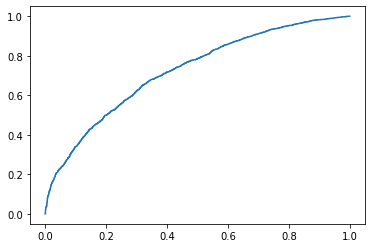

In [31]:
# ROC curve and Area-Under-Curve (AUC)

y_pred_proba = gb.predict_proba(X_validation_sub)[::,1]
y_scores_gb = gb.decision_function(X_validation_sub)

fpr_gb, tpr_gb, _ = roc_curve(y_validation_sub, y_scores_gb)

roc_auc_gb = sk_auc(fpr_gb, tpr_gb)

plt.plot(fpr_gb,tpr_gb,label="data 1, auc="+str(roc_auc_gb))

print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))


#### Other Classifiers:
Let us compare the performance of other classifiers:

In [18]:
lr = LogisticRegression(max_iter=1000)
clf_lr=lr.fit(X_train,y_train)

lr_train_acc = clf_lr.score(X_train,y_train.ravel())
lr_train_acc = str(lr_train_acc.round(2) * 100) + ' %'


lr_test_acc = clf_lr.score(X_validation_sub,y_validation_sub.ravel())
lr_test_acc = str(lr_test_acc.round(2) * 100) + ' %'

print('Logistic Regression:')
print('Training Accuracy= '+ lr_train_acc)
print('Testing Accuracy= '+ lr_test_acc)



Logistic Regression:
Training Accuracy= 61.0 %
Testing Accuracy= 48.0 %


In [19]:
rf=RandomForestClassifier(n_estimators=100,n_jobs=-1)
clf_rf=rf.fit(X_train,y_train)


rf_train_acc = clf_rf.score(X_train,y_train)
rf_train_acc = str(rf_train_acc.round(2) * 100) + ' %'


rf_test_acc = clf_rf.score(X_validation_sub,y_validation_sub.ravel())
rf_test_acc = str(rf_test_acc.round(2) * 100) + ' %'

print('Random Forest:')
print('Training Accuracy='+ rf_train_acc)
print('Testing Accuracy='+ rf_test_acc)


Random Forest:
Training Accuracy=100.0 %
Testing Accuracy=49.0 %


<hr>
<div dir = "rtl">
<ul style = 'list-style-type:square'>
<li> End of Document
</li>


In [41]:
HTML('''<script>
$(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
 });
</script>
''')